<a href="https://colab.research.google.com/github/Rahulraj31/AudioClassification/blob/main/Audio_Classification_Dataprep_and_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Classification using ML/DL

dataset- https://urbansounddataset.weebly.com/download-urbansound8k.html

In [1]:
import tarfile
  
# open file
file = tarfile.open('/content/drive/MyDrive/UrbanSound8K.tar.gz')
  
# extracting file
file.extractall('/content')
  
file.close()

In [2]:
import  matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
filename="/content/UrbanSound8K/audio/fold1/101415-3-0-3.wav" #dog voice

In [3]:
# Let's read a sample data
import librosa
audio_file_path="UrbanSound8K/audio/fold1/101415-3-0-3.wav"
librosa_audio_data,librosa_sample_rate = librosa.load(audio_file_path)

In [4]:
print(librosa_audio_data)

[-0.00060348 -0.00104231 -0.00083736 ... -0.00025618 -0.00023532
 -0.00033718]


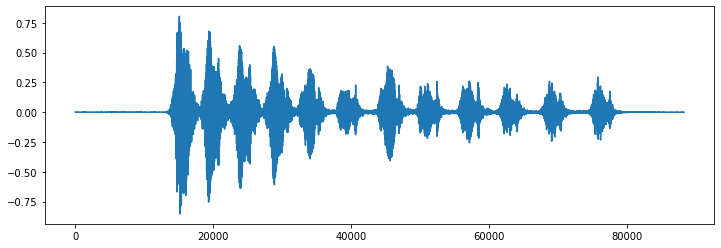

In [5]:
# Lets plot it 
import matplotlib.pyplot as plt
%matplotlib inline
# original audio with 1 channel
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)

### Observation

Here Librosa converts the signal to mono meaning the channel will always be 1

In [6]:
## lets Read with scipy
from scipy.io import wavfile as wav
wav_sample_rate,wav_audio_data = wav.read(audio_file_path)

In [7]:
wav_audio_data

array([-27, -30, -31, ...,  -9, -10, -12], dtype=int16)

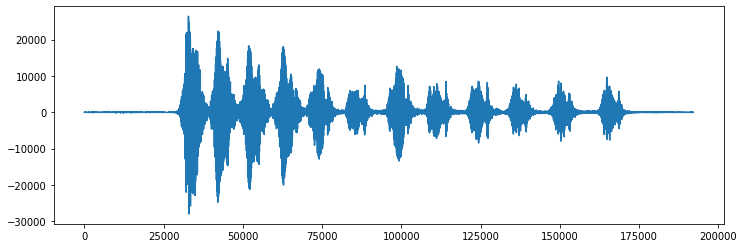

In [8]:
## Lets plot it 
plt.figure(figsize=(12,4))
plt.plot(wav_audio_data)

## Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

**Ref video- https://www.youtube.com/watch?v=4_SH2nfbQZ8&t=0s**

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)



## Extracting MFCC's For every audio file

In [10]:
import pandas as pd
import os
import librosa

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [12]:
import numpy as np
from tqdm import tqdm

# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients

extracted_features=[]

for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [04:19, 13.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8325it [09:55, 18.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [10:22, 14.03it/s]


## Converting extracted features to dataframe

In [13]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265705,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


In [14]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [15]:
X.shape, y.shape

((8732, 40), (8732,))

In [16]:
# Label Encoding
y=np.array(pd.get_dummies(y))

In [17]:
y.shape

(8732, 10)

In [18]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [19]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6549, 40), (2183, 40), (6549, 10), (2183, 10))

## Model Creation

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [21]:

### No of classes
num_labels=y.shape[1]


In [22]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [24]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],optimizer='adam')

In [38]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
205/205 [==============================] - 1s 3ms/step - loss: 0.9842 - accuracy: 0.6711 - val_loss: 0.8093 - val_accuracy: 0.7403

Epoch 00001: val_loss improved from inf to 0.80932, saving model to saved_models/audio_classification.hdf5
Epoch 2/100
205/205 [==============================] - 1s 3ms/step - loss: 0.9738 - accuracy: 0.6728 - val_loss: 0.8053 - val_accuracy: 0.7421

Epoch 00002: val_loss improved from 0.80932 to 0.80525, saving model to saved_models/audio_classification.hdf5
Epoch 3/100
205/205 [==============================] - 1s 3ms/step - loss: 0.9872 - accuracy: 0.6642 - val_loss: 0.8121 - val_accuracy: 0.7393

Epoch 00003: val_loss did not improve from 0.80525
Epoch 4/100
205/205 [==============================] - 1s 3ms/step - loss: 1.0061 - accuracy: 0.6619 - val_loss: 0.8192 - val_accuracy: 0.7421

Epoch 00004: val_loss did not improve from 0.80525
Epoch 5/100
205/205 [==============================] - 1s 3ms/step - loss: 0.9719 - accuracy: 0.6716 - v

In [39]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7709574103355408


In [40]:
prediction_feature=model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [41]:

X_test[1]

array([-466.1843    ,    1.5388287 ,  -34.397358  ,   35.715336  ,
        -15.16693   ,  -18.850813  ,   -0.7415814 ,  -15.999888  ,
        -21.354332  ,    7.650683  ,  -29.03145   ,  -19.142824  ,
         -2.6798913 ,   -8.466883  ,  -14.7660475 ,   -7.004778  ,
         -7.103754  ,    8.887754  ,   14.911873  ,   21.47102   ,
         21.336626  ,    0.9169517 ,  -18.795404  ,   -5.001721  ,
         -0.70152706,    2.9139898 ,   -6.710599  ,  -16.638536  ,
         -9.821647  ,   12.8619585 ,    0.6552978 ,  -23.953394  ,
        -15.200551  ,    9.210791  ,   10.419799  ,   -0.57916135,
         -1.2440345 ,   17.722294  ,   13.837573  ,   -5.164349  ],
      dtype=float32)

In [42]:
prediction_feature.shape

(2183,)


##Testing Some Test Audio Data
Steps


*   Preprocess the new audio data
*   predict the classes
*   Invere transform your Predicted Label

In [43]:
from sklearn.preprocessing import LabelEncoder

In [46]:
filename="/content/UrbanSound8K/audio/fold5/100852-0-0-26.wav"

pre_f= features_extractor(filename)
pre_f=pre_f.reshape(1,-1)
model.predict_classes(pre_f)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([9])

In [51]:
# output is array[9]  mans 9th index of array of labels
print("Classes are -\n",metadata['class'].unique())
print("Class 9 is -\n",metadata['class'].unique()[9])


Classes are -
 ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
Class 9 is -
 drilling
